# Визуализация данных, МФТИ, 2021
## Задание 4, Иванов Вячеслав

In [157]:
import dataclasses
import typing as tp
import warnings

warnings.simplefilter('ignore', FutureWarning)

import networkx as nx
import numpy as np
import sklearn.datasets
import sklearn.decomposition
import sklearn.metrics
import sklearn.neighbors

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d 
import seaborn as sns

# Введение

Ниже приведена реализация алгоритма IsoMap, который строит маломерное вложение (размерности $d$) данных с сохранением матрицы кратчайших расстояний, посчитанной по kNN-графу, который, в свою очередь, построен по точкам в исходном признаковом пространстве с заданной метрикой.

Искомую проекцию задают собственные вектора при $d$ максимальных собственных значениях ядра -- матрицы $-HSH/2$, где $S$ -- матрица квадратов элементов матрицы $G$, а $H := I_{n} - \mathbf{1} / n $ (в соответствии с оригинальной статьёй).

Для вычисления таких собственных векторов можно использовать алгоритм KernelPCA с ядром, заданным матрицей $-S$. Приведенная ниже реализация использует именно его

# Реализация IsoMap

In [240]:
@dataclasses.dataclass()
class IsoMap:
    n_components: int = 2
    n_neighbors: int = 5
    metric: str = 'euclidean'
    random_state: int = 42
    
    geodesics_matrix_: tp.Optional[np.ndarray] = None
    kernel_matrix_: tp.Optional[np.ndarray] = None
    embeddings_: tp.Optional[np.ndarray] = None
    
    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        self.geodesics_matrix_ = self._compute_geodesics_matrix(
            self._construct_knn_graph(X)
        )
        self.kernel_ = self._compute_kernel(self.geodesics_matrix_)
        self.embeddings_ = self._compute_embeddings(self.kernel_)
        return self.embeddings_
        
    def _construct_knn_graph(self, X: np.ndarray) -> nx.Graph:
        n_samples = X.shape[0]
        knn_graph = nx.Graph()
        knn_graph.add_nodes_from(np.arange(n_samples))
        knn_graph_matrix = sklearn.neighbors.KNeighborsTransformer(
            n_neighbors=self.n_neighbors, metric=self.metric
        ).fit_transform(X).tocoo()
        knn_graph.add_weighted_edges_from(
            list(
                zip(
                    knn_graph_matrix.row, 
                    knn_graph_matrix.col, 
                    knn_graph_matrix.data
                )
            )
        )
        return knn_graph
    
    def _compute_geodesics_matrix(self, graph: nx.Graph) -> np.ndarray:
        all_shortest_path_lengths = (
            nx.algorithms.shortest_paths.weighted
            .all_pairs_dijkstra_path_length(graph)
        )
        n_points = graph.number_of_nodes()
        geodesics_matrix = np.zeros((n_points, n_points))
        for source, path_lengths_dict in all_shortest_path_lengths:
            for sink, length in path_lengths_dict.items():
                geodesics_matrix[source, sink] = length
                geodesics_matrix[sink, source] = length
        return geodesics_matrix
    
    def _compute_kernel(self, geodesics_matrix: np.ndarray) -> np.ndarray:
        return -0.5 * (geodesics_matrix**2)
    
    def _compute_embeddings(self, kernel: np.ndarray) -> np.ndarray:
        return sklearn.decomposition.KernelPCA(
            n_components=self.n_components,
            kernel='precomputed',
            random_state=self.random_state
        ).fit_transform(kernel)

# Проверка на датасете Swiss Roll

Swiss Roll -- типичный пример датасета, на которых простейшие алгоритмы понижения размерности в духе PCA не могут показать хороший результат. Представьте себе узкую полоску бумаги. Мысленно сверните её в спираль. Именно так устроен этот датасет. 

Для Swiss Roll стандартное евклидово расстояние в трёхмерном пространстве неадекватно, т.к. передвигаться между точками можно только по поверхности "листа бумаги". А вот матрица кратчайших расстояний в графе k ближайших соседей, напротив, очень хорошо приближает истинную геометрию на этом многообразии.

In [237]:
point_cloud, colors = sklearn.datasets.make_swiss_roll(
    n_samples=1000, 
    noise=1.0, 
    random_state=179
)

Посмотрим на данные в исходном признаковом пространстве

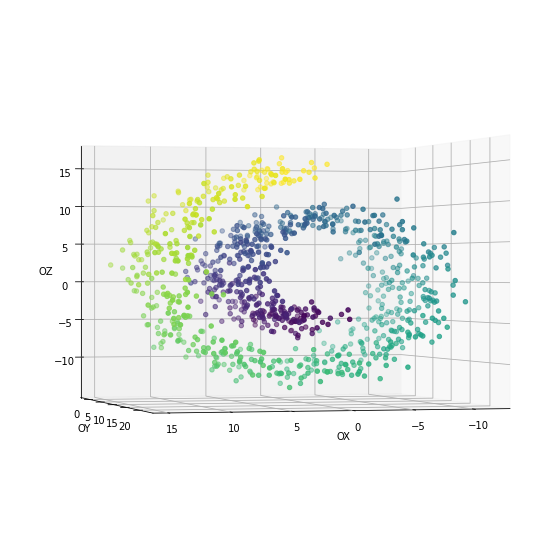

In [257]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
xs, ys, zs = point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]
ax.scatter(xs, ys, zs, c=colors)
ax.set_xlabel('OX')
ax.set_ylabel('OY')
ax.set_zlabel('OZ')
ax.view_init(0, 75)
plt.show()

In [238]:
isomap = IsoMap()
embeddings = isomap.fit_transform(point_cloud)

Посмотрим, как выглядит вложение. Цвет кодирует сегмент "листа бумаги", на котором точка находилась в исходном пространстве.

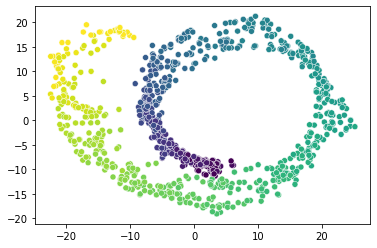

In [258]:
sns.scatterplot(embeddings[:, 0], embeddings[:, 1], c=colors);

Видим, что геометрия исходного пространства передана корректно. Посмотрим на распределение ошибок:

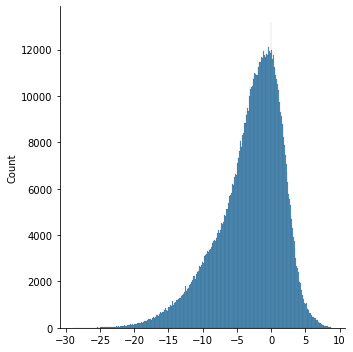

In [261]:
pairwise_distances_between_embeddings = (
    sklearn.metrics.pairwise_distances(embeddings) 
)

sns.displot(
   np.ravel(
        pairwise_distances_between_embeddings
        - isomap.geodesics_matrix_
   ),
);

Алгоритм ожидаемо недопредсказывает (т.к. проекция это преобразование с потерей информации), но дисперсия ошибки не слишком велика. 

---

Посмотрим на распределение расстояний в исходном пространстве:

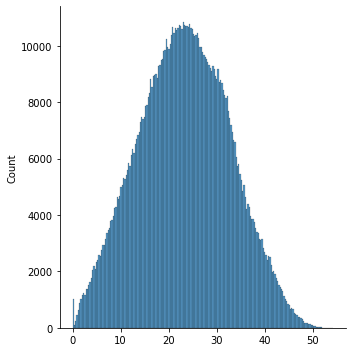

In [260]:
sns.displot(np.ravel(isomap.geodesics_matrix_));

И на распределение расстояний после проекции:

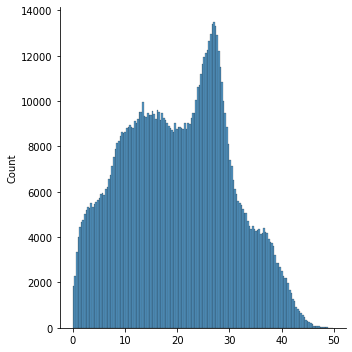

In [262]:
sns.displot(
   np.ravel(pairwise_distances_between_embeddings),
);

Выглядит разумно. Спасибо за внимание!